# Regridding comparison

This is not a thorough comparison of regridding methods, just a fast simple comparison. Use this to be used as a starting point for a more indepth comparison.

## Software used
- [xESMF](https://xesmf.readthedocs.io/en/latest/index.html)
- [xarray](http://xarray.pydata.org/en/stable/)
- [SciPy](https://www.scipy.org/)
- [pyinterp](https://pangeo-pyinterp.readthedocs.io/en/latest/)

## Environment
Below is the command to create the conda environment to use. This uses the mamba, a reimplementation of conda in c++. You can replace mamba with conda and achieve the same result.

```shell
mamba create -n regridding -c conda-forge python=3.8.8 xarray netcdf4 dask distributed matplotlib ipykernel xesmf scipy pyinterp cartopy
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

# xESMF

Plot initial air data.

## Rectilinear grid

Create a 1.0 x 1.5 degree grid. 

/home/jovyan/conda-envs/regridding/lib/python3.8/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/jovyan/conda-envs/regridding/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


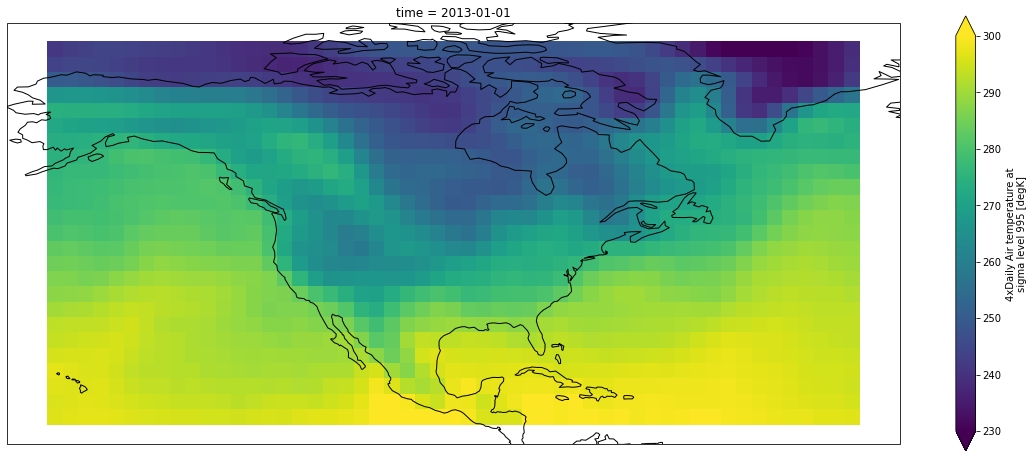

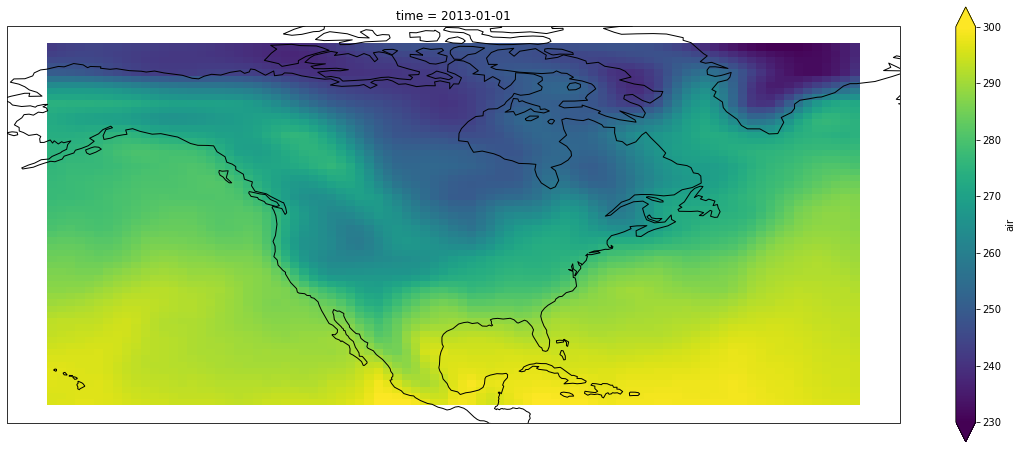

In [3]:
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.air.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

grid_10_15 = xr.Dataset(
    {
        'lat': (['lat'], np.arange(17, 75, 1.0)),
        'lon': (['lon'], np.arange(200, 330, 1.5)),
    }
)
regridder = xe.Regridder(ds.air, grid_10_15, 'bilinear')
dr_air_out = regridder(ds.air)
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
dr_air_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

## Curvilinear grid

Here we plot the initial data, view the grid then regrid and visualize the output.

/home/jovyan/conda-envs/regridding/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


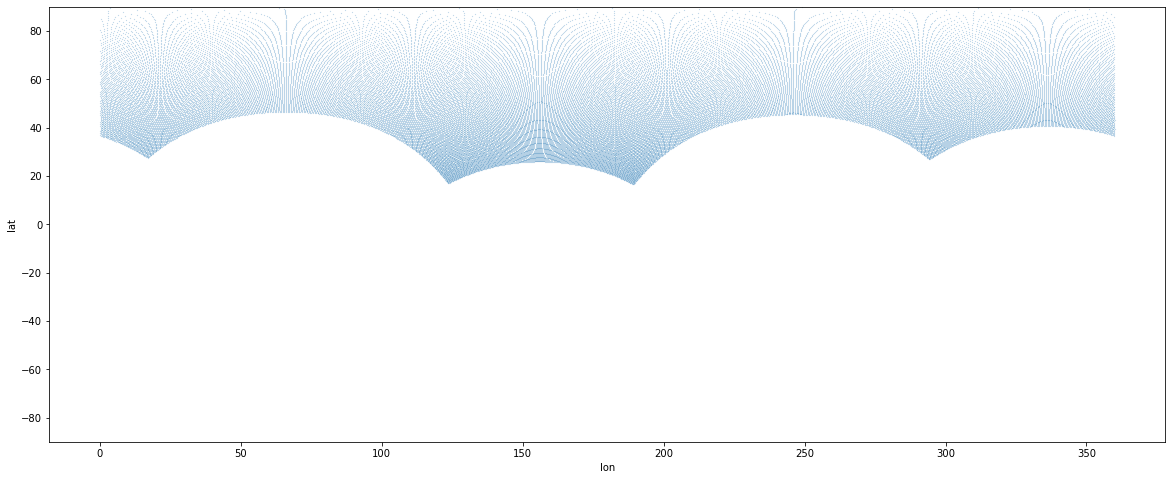

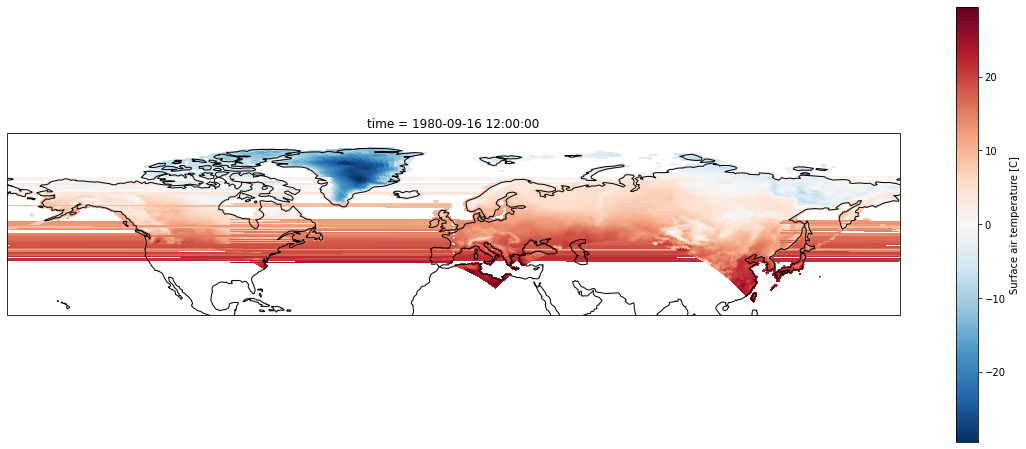

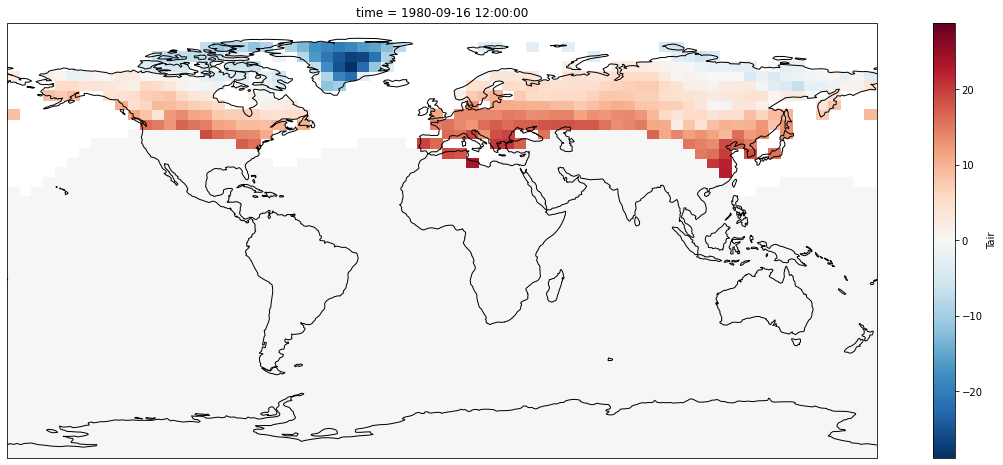

In [4]:
rasm = xr.tutorial.open_dataset('rasm')
rasm = rasm.rename({"xc": "lon", "yc": "lat"})

plt.figure(figsize=(20, 8))
plt.scatter(rasm.Tair['lon'], rasm.Tair['lat'], s=0.01)  # plot grid locations
plt.ylim([-90, 90])
plt.xlabel('lon')
plt.ylabel('lat')

plt.figure(figsize=(20, 8));
ax = plt.axes(projection=ccrs.PlateCarree());
rasm.Tair.isel(time=0).plot.pcolormesh(ax=ax, x="lon", y="lat");
ax.coastlines();

grid_5_4 = xe.util.grid_global(5, 4)
regridder = xe.Regridder(rasm, grid_5_4, 'bilinear')
dr_curve_out = regridder(rasm.Tair)
plt.figure(figsize=(20, 8));
ax = plt.axes(projection=ccrs.PlateCarree())
dr_curve_out[0].plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

# xarray interp_like

Uses 1.0 x 1.5 grid from xESMF rectilinear example.

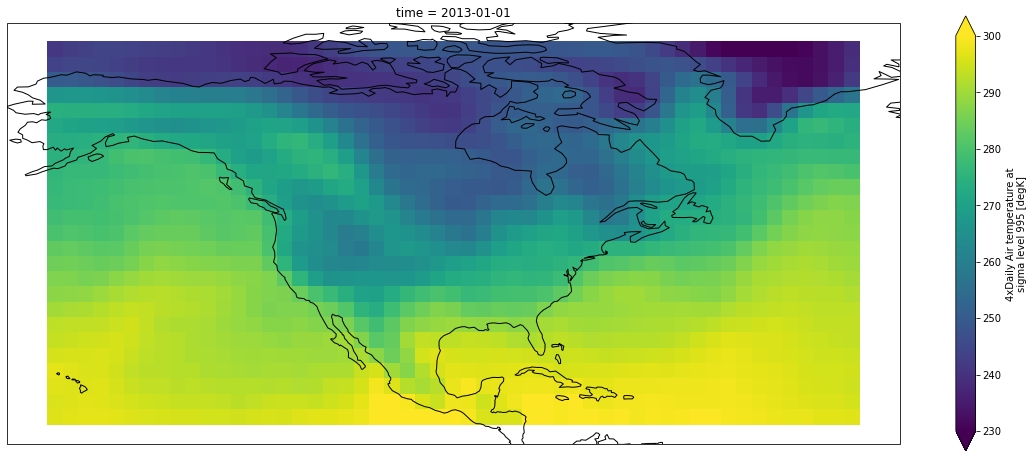

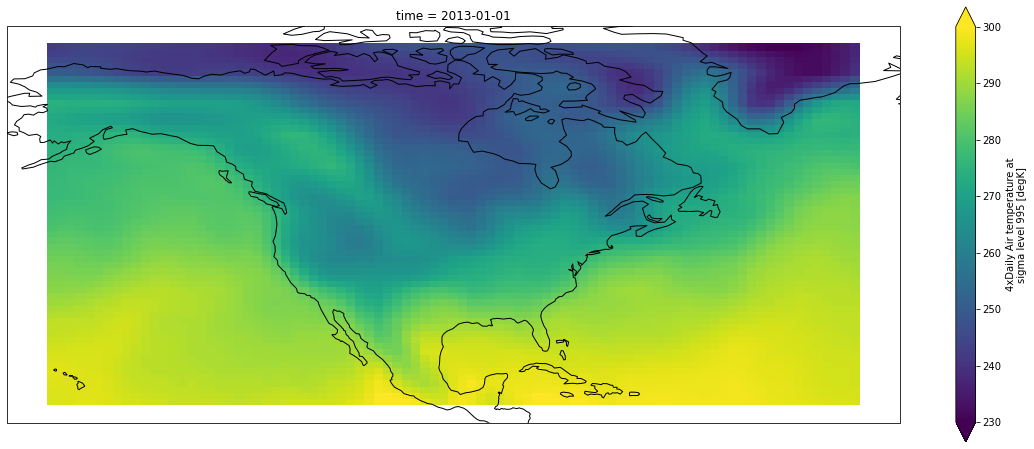

In [5]:
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.air.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

interp_regrid = ds.air.interp_like(grid_10_15)
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
interp_regrid.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

# Scipy griddata

# **Work in progress**

(53, 25) (53, 25)
(59, 74) (59, 74)
(59, 74)
[[220.  221.5 223.  ... 326.5 328.  329.5]
 [220.  221.5 223.  ... 326.5 328.  329.5]
 [220.  221.5 223.  ... 326.5 328.  329.5]
 ...
 [220.  221.5 223.  ... 326.5 328.  329.5]
 [220.  221.5 223.  ... 326.5 328.  329.5]
 [220.  221.5 223.  ... 326.5 328.  329.5]]


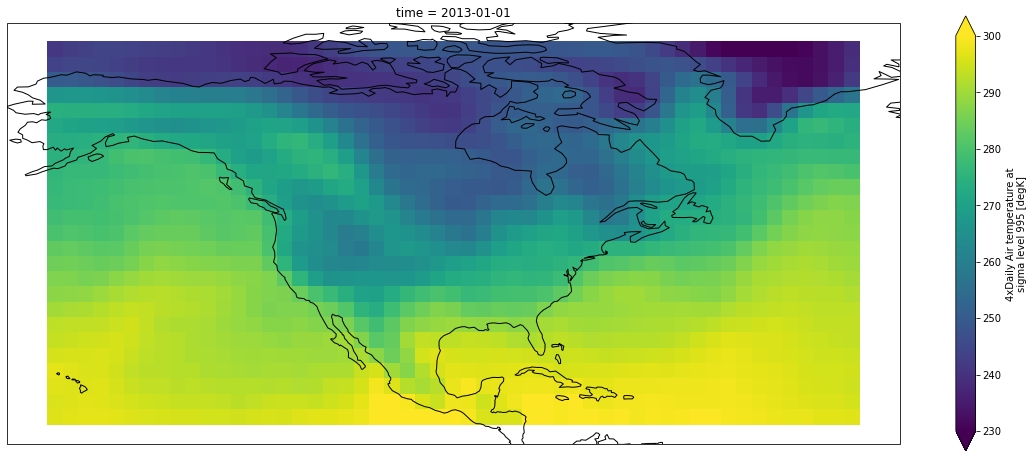

In [6]:
import scipy

plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.air.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

ox, oy = np.meshgrid(ds.lat.values, ds.lon.values)
print(ox.shape, oy.shape)
mx, my = np.meshgrid(np.arange(16, 75, 1.0), np.arange(220, 330, 1.5), indexing='ij')
print(mx.shape, my.shape)
new_data = scipy.interpolate.griddata((ox.flatten(), oy.flatten()), ds.air[0].values.flatten(), (mx.flatten(), my.flatten()), method='cubic')

new_data = new_data.reshape(mx.shape)
print(new_data.shape)
coords = {
    'lon': np.arange(16, 75, 1.0),
    'lat': np.arange(200, 330, 1.5)
}
print(my[:])
# new_dr = xr.DataArray(new_data, coords=coords, dims=['lon', 'lat'])

# pyinterp

('time', 'lat', 'lon')
(2920, 59, 87)
(2920, 59, 87)
(2920, 59, 87)
(2920, 25, 53) (2920, 59, 87)


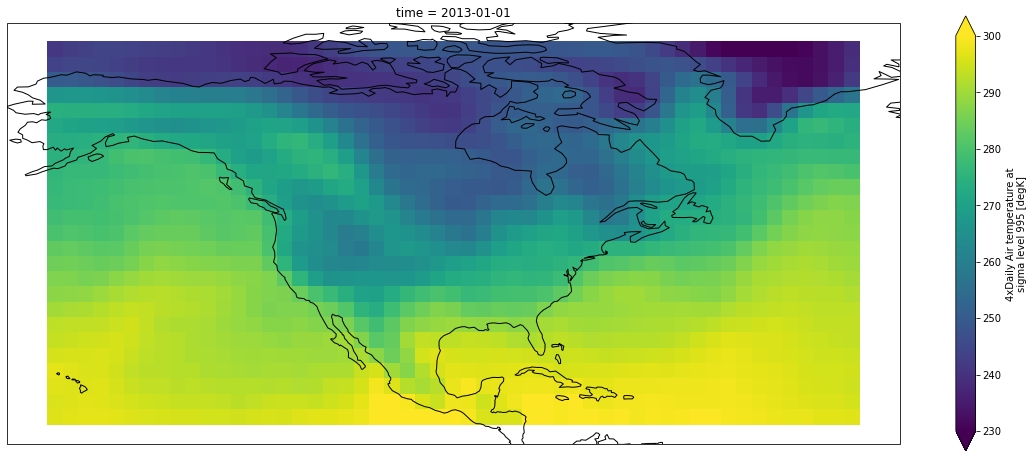

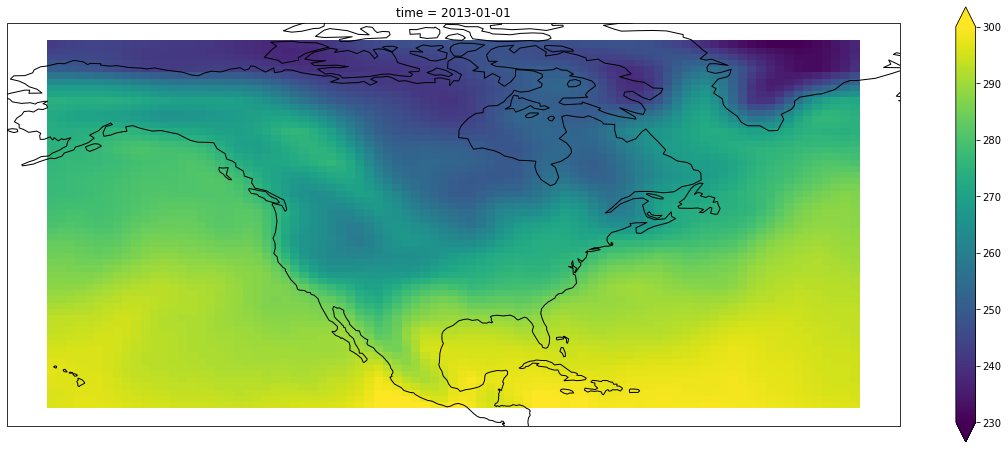

In [7]:
import numpy as np
import pyinterp.backends.xarray as pbx

plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.air.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

interpolator = pbx.RegularGridInterpolator(ds.air)

print(ds.air.dims)

mx, my, mz = np.meshgrid(ds.air.time, np.arange(16, 75, 1.0), np.arange(200, 330, 1.5), indexing='ij')

print(mx.shape)
print(my.shape)
print(mz.shape)

data = interpolator(dict(lon=mz.flatten(), lat=my.flatten(), time=mx.flatten()))

data = data.reshape(mx.shape)

print(ds.air.values.shape, data.shape)

coords = {
    'time': ds.air.time,
    'lat': np.arange(16, 75, 1.0),
    'lon': np.arange(200, 330, 1.5)
}

ds_out_interp = xr.DataArray(data, dims=['time', 'lat', 'lon'], coords=coords)

plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out_interp.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();